<h1> <center><font color='green' > <b>AGN Image Classification for SDSS</b></font> </center></h1>

# Model Building
by Sicong Huang <br> \
<font color='blue'>Python Version: 3.6.5 <br>
SDSS Version: DR8

# Analytic Approach:
<font color='green'>__Deep learning__:
- Shallow CNN
- ResNet

# IMPORT LIBRARIES

In [54]:
# System
import os
from io import BytesIO
from tqdm import tqdm
import h5py

# Web Scraping

# Data Analysis
import pandas as pd
import numpy as np

# sklearn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score, f1_score

# Neural Network
from tensorflow import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

import keras.backend as K
K.set_image_data_format('channels_last')

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

%matplotlib inline

In [64]:
# Image directory
Image_path = '/data/blackbase/Images/'

# datasets
train_file = Image_path+'train_sdss.h5'
dev_file = Image_path+'dev_sdss.h5'

# Functions

In [62]:
def load_dataset(train_file, dev_file):
    train_dataset = h5py.File(train_file, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    dev_dataset = h5py.File(dev_file, "r")
    dev_set_x_orig = np.array(dev_dataset["dev_set_x"][:]) # your test set features
    dev_set_y_orig = np.array(dev_dataset["dev_set_y"][:]) # your test set labels

    #classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    dev_set_y_orig = dev_set_y_orig.reshape((1, dev_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, dev_set_x_orig, dev_set_y_orig

In [57]:
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(3,3))
    sns.set(font_scale=1.5) 
    ax = sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    ax.set(xlabel='Predicted Values', ylabel='Actual Value')
    plt.show()

# Read train/dev/test sets

In [65]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset(train_file, dev_file)

# Normalize image vectors
X_train = X_train_orig/255. # the values of the pixels can range from 0 and 255
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 24000
number of test examples = 6000
X_train shape: (24000, 64, 64, 3)
Y_train shape: (24000, 1)
X_test shape: (6000, 64, 64, 3)
Y_test shape: (6000, 1)


In [66]:
# Set star = galaxy = 1
Y_train = np.where(Y_train == 2, 1, Y_train)
Y_test = np.where(Y_test == 2, 1, Y_test)

# Data Modeling

## Shallow CNN in Keras
<font color='green'>Input => ZeroPadding => CNN => ReLU => MAXPOOL => FC => => Sigmoid => Output

In [67]:
def Image_classifier(input_shape):
    """    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='Image_Classifier')

    
    ### END CODE HERE ###
    
    return model

In [68]:
# early stoping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [69]:
im_cl = Image_classifier(X_train.shape[1:])

In [70]:
im_cl.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [71]:
im_cl.summary()

Model: "Image_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_103 (Activation)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)        

In [73]:
history = im_cl.fit(X_train, 
          Y_train,
          validation_data=(X_test, Y_test),
          callbacks=[callback],
          epochs=200, 
          batch_size=256,   
          verbose=1)

Epoch 1/200
94/94 [==============================] - 39s 413ms/step - loss: 0.4333 - accuracy: 0.8166 - val_loss: 0.5644 - val_accuracy: 0.7692
Epoch 2/200
94/94 [==============================] - 38s 408ms/step - loss: 0.3972 - accuracy: 0.8349 - val_loss: 0.4929 - val_accuracy: 0.8000
Epoch 3/200
94/94 [==============================] - 39s 420ms/step - loss: 0.3790 - accuracy: 0.8452 - val_loss: 0.4643 - val_accuracy: 0.8212
Epoch 4/200
94/94 [==============================] - 39s 417ms/step - loss: 0.3590 - accuracy: 0.8546 - val_loss: 0.6260 - val_accuracy: 0.6607
Epoch 5/200
94/94 [==============================] - 40s 423ms/step - loss: 0.3454 - accuracy: 0.8579 - val_loss: 0.4999 - val_accuracy: 0.7630
Epoch 6/200
94/94 [==============================] - 40s 425ms/step - loss: 0.3501 - accuracy: 0.8568 - val_loss: 0.4777 - val_accuracy: 0.7998
Epoch 7/200
94/94 [==============================] - 40s 429ms/step - loss: 0.3401 - accuracy: 0.8602 - val_loss: 0.4414 - val_accuracy:

In [75]:
### START CODE HERE ### (1 line)
preds = im_cl.evaluate(x=X_test, y=Y_test, batch_size=256)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

24/24 [==============================] - 2s 90ms/step - loss: 0.6616 - accuracy: 0.7737

Loss = 0.6616111397743225
Test Accuracy = 0.7736666798591614


188/188 [==============================] - 10s 51ms/step
The training set f1 score is 0.8653622716921504
the dev set f1 score is 0.7434831885153003


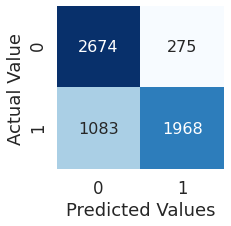

In [76]:
yhat_dev_cnn0 = im_cl.predict(X_test, batch_size=128, verbose=1)
yhat_dev_cnn = np.where(yhat_dev_cnn0 >= 0.5, 1, 0)
#yhat_dev = np.argmax(yhat_dev0, axis=1)
yhat_train_cnn0 = im_cl.predict(X_train, batch_size=128, verbose=1)
yhat_train_cnn = np.where(yhat_train_cnn0 >= 0.5, 1, 0)
#yhat_train = np.argmax(yhat_train0, axis=1)
print(f"The training set f1 score is {f1_score(Y_train, yhat_train_cnn)}")
print(f"the dev set f1 score is {f1_score(Y_test, yhat_dev_cnn)}") 

# Plot Confusion Matrix
conf_matrix(Y_test, yhat_dev_cnn)

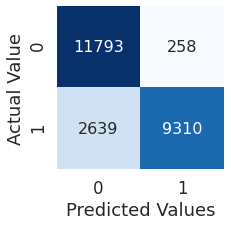

In [77]:
conf_matrix(Y_train, yhat_train_cnn)

In [78]:
# save model
im_cl.save('shallow_cnn.pd')

INFO:tensorflow:Assets written to: shallow_cnn.pd/assets


In [79]:
%store yhat_train_cnn
%store yhat_dev_cnn

Stored 'yhat_train_cnn' (ndarray)
Stored 'yhat_dev_cnn' (ndarray)


In [80]:
yhat_dev_prob_cnn = yhat_dev_cnn0
yhat_train_prob_cnn = yhat_train_cnn0
%store yhat_dev_prob_cnn
%store yhat_train_prob_cnn

Stored 'yhat_dev_prob_cnn' (ndarray)
Stored 'yhat_train_prob_cnn' (ndarray)


# ResNet (50 Layers)

In [81]:
# identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [82]:
# convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [48]:
def ResNet50(input_shape = (64, 64, 3)):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2))(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [83]:
resnet50 = ResNet50(input_shape = (64, 64, 3))

In [84]:
resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [85]:
resnet50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [87]:
# early stoping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [88]:
history = resnet50.fit(X_train, 
          Y_train,
          validation_data=(X_test, Y_test),
          callbacks=[callback],
          epochs=30, 
          batch_size=128,   
          verbose=1)

Epoch 1/30
188/188 [==============================] - 378s 2s/step - loss: 0.7878 - accuracy: 0.7445 - val_loss: 1.1347 - val_accuracy: 0.4915
Epoch 2/30
188/188 [==============================] - 369s 2s/step - loss: 0.4255 - accuracy: 0.8483 - val_loss: 11.6134 - val_accuracy: 0.5325
Epoch 3/30
188/188 [==============================] - 382s 2s/step - loss: 0.3753 - accuracy: 0.8514 - val_loss: 0.7017 - val_accuracy: 0.8017
Epoch 4/30
188/188 [==============================] - 376s 2s/step - loss: 0.3298 - accuracy: 0.8725 - val_loss: 0.4170 - val_accuracy: 0.8453
Epoch 5/30
188/188 [==============================] - 372s 2s/step - loss: 0.3527 - accuracy: 0.8621 - val_loss: 0.6939 - val_accuracy: 0.7268
Epoch 6/30
188/188 [==============================] - 377s 2s/step - loss: 0.4267 - accuracy: 0.8343 - val_loss: 10.0166 - val_accuracy: 0.5150
Epoch 7/30
188/188 [==============================] - 385s 2s/step - loss: 0.3823 - accuracy: 0.8499 - val_loss: 0.3739 - val_accuracy: 0.85

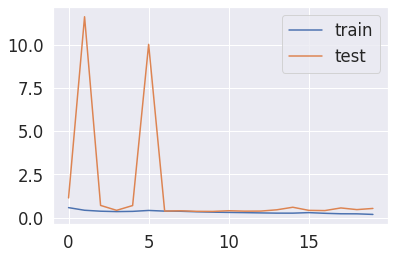

In [89]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [100]:
### START CODE HERE ### (1 line)
preds = resnet50.evaluate(x=X_test, y=Y_test, batch_size=256)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

24/24 [==============================] - 12s 498ms/step - loss: 0.5265 - accuracy: 0.8242

Loss = 0.5265131592750549
Test Accuracy = 0.8241666555404663


In [101]:
yhat_dev_res0 = resnet50.predict(X_test, batch_size=128, verbose=1)
yhat_dev_res = np.where(yhat_dev_res0 >= 0.5, 1, 0)
#yhat_dev = np.argmax(yhat_dev0, axis=1)
yhat_train_res0 = resnet50.predict(X_train, batch_size=128, verbose=1)
yhat_train_res = np.where(yhat_train_res0 >= 0.5, 1, 0)
#yhat_train = np.argmax(yhat_train0, axis=1)
print(f"The training set f1 score is {f1_score(Y_train, yhat_train_res)}")
print(f"the dev set f1 score is {f1_score(Y_test, yhat_dev_res)}") 

188/188 [==============================] - 46s 243ms/step
The training set f1 score is 0.9070405128799289
the dev set f1 score is 0.8421367649259316


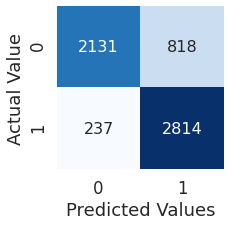

In [102]:
# Plot Confusion Matrix
conf_matrix(Y_test, yhat_dev_res)

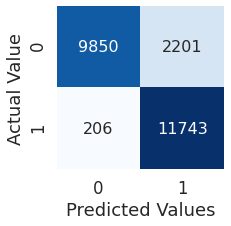

In [103]:
conf_matrix(Y_train, yhat_train_res)

In [ ]:
# save model
resnet50.save('resnet_50.pd')

In [ ]:
%store yhat_train_res
%store yhat_dev_res

In [ ]:
yhat_dev_prob_res = yhat_dev_res0
yhat_train_prob_res = yhat_train_res0
%store yhat_dev_prob_res
%store yhat_train_prob_res